In [13]:
%pip install pandas
%pip install numpy
%pip install torch
%pip install scikit-learn
%pip install matplotlib
%pip install tqdm
%pip install google
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Hyperparameters
NUM_CLASSES = 2  # Binary classification (0: no signal peptide, 1: signal peptide)
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
MAX_LENGTH = 100  # maybe adjust
WINDOW_SIZE = 35  # sliding window (odd because model predicts center residue)
STRIDE = 1  # Step size

Using device: cpu


In [14]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PBLRost/"
FASTA_PATH = os.path.join(DRIVE_PATH, "data/complete_set_unpartitioned.fasta")
MODEL_PATH = os.path.join(DRIVE_PATH, "models/2state_ohe_lstm_lin.pt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
aas = 'ARNDCEQGHILKMFPSTWYV'
aa2idx = {aa: i for i, aa in enumerate(aas)}
idx2aa = {i: aa for aa, i in aa2idx.items()}
num_aa = len(aas)

def one_hot_encode_window(seq_window):
    """One-hot encode a sequence window"""
    encoding = np.zeros((len(seq_window), num_aa))

    for i, aa in enumerate(seq_window):
        if aa in aa2idx:
            encoding[i, aa2idx[aa]] = 1
        # Unknown amino acids remain as zero vectors (as is the default)
    return encoding

In [16]:
def create_sliding_windows(sequence, labels, window_size, stride=1):
    """Create sliding windows from sequence and corresponding labels"""
    windows = []
    window_labels = []
    positions = []

    # Pad sequence for edge cases
    pad_size = window_size // 2 # so starts classification after padding, at first real encoding
    padded_seq = 'X' * pad_size + sequence + 'X' * pad_size
    padded_labels = [0] * pad_size + labels + [0] * pad_size

    # Create sliding windows
    for i in range(0, len(sequence), stride):
        start_idx = i
        end_idx = i + window_size

        if end_idx <= len(padded_seq):
            window_seq = padded_seq[start_idx:end_idx]
            # Label for the center position of the window
            center_idx = start_idx + pad_size # residue to predict
            if center_idx < len(padded_labels):
                center_label = padded_labels[center_idx]

                windows.append(window_seq)
                window_labels.append(center_label)
                positions.append(i)  # Original position in sequence

    return windows, window_labels, positions

In [17]:
def load_and_preprocess_data(fasta_path):
    """Load FASTA data and preprocess for sliding window approach"""
    records = []

    with open(fasta_path, "r") as f:
        current_record = None
        for line in f:
            if line.startswith(">"):
                if current_record is not None:
                    if current_record["sequence"] is not None and current_record["label"] is not None:
                        records.append(current_record)

                uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
                current_record = {
                    "uniprot_ac": uniprot_ac,
                    "kingdom": kingdom,
                    "type": type_,
                    "sequence": None,
                    "label": None
                }
            else:
                if current_record["sequence"] is None:
                    current_record["sequence"] = line.strip()
                elif current_record["label"] is None:
                    current_record["label"] = line.strip()

        # Add last record
        if current_record is not None:
            if current_record["sequence"] is not None and current_record["label"] is not None:
                records.append(current_record)

    print(f"Total records loaded: {len(records)}")

    # Convert to DataFrame
    df_raw = pd.DataFrame(records)

    # Filter out sequences with 'P' in labels (if needed)
    df = df_raw[~df_raw["label"].str.contains("P")]

    # Map signal peptide types to binary classification
    df["has_signal_peptide"] = df["type"].map({
        "NO_SP": 0,
        "LIPO": 1,
        "SP": 1,
        "TAT": 1,
        "TATLIPO": 1
    })

    # Balance the dataset at sequence level first
    df_majority = df[df["has_signal_peptide"] == 0]
    df_minority = df[df["has_signal_peptide"] == 1]

    if not df_minority.empty and not df_majority.empty:

        n_samples = min(len(df_majority), 5000) # Limit samples to 5000 to prevent high ram usage
        df_majority_sampled = resample(
            df_majority,
            replace=False, # sample without replacement
            n_samples=n_samples,
            random_state=42
        )
        df_balanced = pd.concat([df_majority_sampled, df_minority]) # Include all minority samples
    else:
        df_balanced = df.copy()


    # Convert residue-level labels to binary
    label_map = {'S': 1, 'T': 1, 'L': 1, 'I': 0, 'M': 0, 'O': 0}

    # Create sliding windows for all sequences
    all_windows = []
    all_labels = []
    all_seq_ids = []

    for idx, row in df_balanced.iterrows():
        sequence = row["sequence"]
        label_string = row["label"]

        # Convert label string to binary array
        residue_labels = [label_map.get(c, 0) for c in label_string]

        # Skip sequences where label length doesn't match sequence length
        if len(residue_labels) != len(sequence):
            print("A sequence length is not equal to the label length")
            continue

        # Create sliding windows for this sequence
        windows, window_labels, positions = create_sliding_windows(
            sequence, residue_labels, WINDOW_SIZE, STRIDE
        )

        all_windows.extend(windows)
        all_labels.extend(window_labels) # labels for center residue
        all_seq_ids.extend([idx] * len(windows)) # links windows and sequences (later split by seq id)

    print(f"Total windows created: {len(all_windows)}")
    print(f"Signal peptide windows: {sum(all_labels)}")
    print(f"Non-signal peptide windows: {len(all_labels) - sum(all_labels)}")

    return all_windows, all_labels, all_seq_ids

In [18]:
class SlidingWindowDataset(Dataset):
    def __init__(self, windows, labels, window_size):
        self.windows = windows
        self.labels = labels
        self.window_size = window_size

        # Pre-encode all windows
        self.encoded_windows = []
        for window in windows:
            encoded = one_hot_encode_window(window)
            self.encoded_windows.append(encoded)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return {
            'window': torch.tensor(self.encoded_windows[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [19]:
class SlidingWindowSignalPeptideClassifier(nn.Module):
    def __init__(self, window_size, num_aa, hidden_dim=128, num_layers=2, use_cnn=True, use_lstm=False, lstm_hidden_dim=64, lstm_layers=3):
        super().__init__()
        self.window_size = window_size
        self.num_aa = num_aa
        self.use_cnn = use_cnn
        self.use_lstm = use_lstm

        if use_cnn:
            # CNN approach - better for local patterns
            self.conv_layers = nn.Sequential(
                nn.Conv1d(num_aa, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Conv1d(64, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.AdaptiveAvgPool1d(1)  # Global average pooling
            )
            fc_input_dim = 32
        elif use_lstm:
            # LSTM approach - for sequential dependencies
            self.lstm = nn.LSTM(
                input_size=num_aa,
                hidden_size=lstm_hidden_dim,
                num_layers=lstm_layers,
                batch_first=True,
                bidirectional=True
            )
            fc_input_dim = lstm_hidden_dim * 2  # bidirectional
        else:
            # MLP approach - flatten the window
            fc_input_dim = window_size * num_aa

        # Final classification layers
        layers = []
        in_dim = fc_input_dim

        for _ in range(num_layers):
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            in_dim = hidden_dim

        # Binary classification output
        layers.append(nn.Linear(hidden_dim, 1))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        # x: [batch_size, window_size, num_aa]
        batch_size = x.size(0)

        if self.use_cnn:
            # Transpose for Conv1d: [batch_size, num_aa, window_size]
            x = x.transpose(1, 2)
            x = self.conv_layers(x)
            x = x.view(batch_size, -1)  # Flatten
        elif self.use_lstm:
            # LSTM expects [batch_size, seq_len, input_size]
            lstm_out, _ = self.lstm(x)
            # Use the last output from both directions
            x = torch.cat([lstm_out[:, -1, :self.lstm.hidden_size], lstm_out[:, 0, self.lstm.hidden_size:]], dim=1)
        else:
            # Flatten for MLP
            x = x.view(batch_size, -1)

        logits = self.classifier(x)
        return logits.squeeze(-1)  # Remove last dimension for binary classification

In [20]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    """Train the sliding window model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            windows = batch['window'].to(device)
            labels = batch['label'].to(device).float()

            optimizer.zero_grad()

            logits = model(windows)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                windows = batch['window'].to(device)
                labels = batch['label'].to(device).float()

                logits = model(windows)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                val_batches += 1

                # Calculate accuracy
                predictions = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_batches
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)

        # Learning rate scheduling for when val loss plateaus
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Saves the best model to file, important cuz val loss can increase again
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_PATH)

    return train_losses, val_losses

In [21]:
# compute percentage of false predicted labels
def sequence_level_accuracy(predictions, labels):
    correct = 0
    total = 0
    for pred, label in zip(predictions, labels):
        if len(pred) != len(label):
            min_len = min(len(pred), len(label))
            pred = pred[:min_len]
            label = label[:min_len]
        total += 1
        if (pred == label).all():
            correct += 1
    return correct / total

In [22]:
def evaluate_model(model, test_loader, device):
    """Evaluate the sliding window model"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            windows = batch['window'].to(device)
            labels = batch['label'].to(device)

            logits = model(windows)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.5).long()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['No Signal', 'Signal']))

    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    mcc = matthews_corrcoef(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    return all_preds, all_labels, all_probs

def predict_sequence(model, sequence, window_size, device, threshold=0.5):
    """Predict signal peptide positions for a full sequence"""
    model.eval()

    # Create dummy labels (we don't need them for prediction)
    dummy_labels = [0] * len(sequence)

    # Create sliding windows
    windows, _, positions = create_sliding_windows(sequence, dummy_labels, window_size, stride=1)

    # Encode windows
    encoded_windows = [one_hot_encode_window(window) for window in windows]

    predictions = []
    probabilities = []

    with torch.no_grad():
        for encoded_window in encoded_windows:
            window_tensor = torch.tensor(encoded_window, dtype=torch.float32).unsqueeze(0).to(device)
            logit = model(window_tensor)
            prob = torch.sigmoid(logit).item()
            pred = int(prob > threshold)

            predictions.append(pred)
            probabilities.append(prob)

    return predictions, probabilities, positions

Total records loaded: 25693


/tmp/ipython-input-17-3872674278.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_signal_peptide"] = df["type"].map({


Total windows created: 806011
Signal peptide windows: 153863
Non-signal peptide windows: 652148
Train windows: 515774
Validation windows: 129009
Test windows: 161228
Model parameters: 275,841


Epoch 1/10: 100%|██████████| 16118/16118 [22:21<00:00, 12.01it/s, loss=0.0371]


Epoch 1/10 - Train Loss: 0.0980, Val Loss: 0.0914, Val Acc: 0.9678


Epoch 2/10: 100%|██████████| 16118/16118 [23:13<00:00, 11.57it/s, loss=0.1491]


Epoch 2/10 - Train Loss: 0.0644, Val Loss: 0.0924, Val Acc: 0.9698


Epoch 3/10: 100%|██████████| 16118/16118 [23:11<00:00, 11.58it/s, loss=0.0241]


Epoch 3/10 - Train Loss: 0.0481, Val Loss: 0.0986, Val Acc: 0.9728


Epoch 4/10: 100%|██████████| 16118/16118 [23:10<00:00, 11.59it/s, loss=0.2053]


Epoch 4/10 - Train Loss: 0.0354, Val Loss: 0.1003, Val Acc: 0.9747


Epoch 5/10: 100%|██████████| 16118/16118 [23:42<00:00, 11.33it/s, loss=0.0577]


Epoch 5/10 - Train Loss: 0.0275, Val Loss: 0.1113, Val Acc: 0.9735


Epoch 6/10: 100%|██████████| 16118/16118 [23:07<00:00, 11.61it/s, loss=0.0881]


Epoch 6/10 - Train Loss: 0.0163, Val Loss: 0.1229, Val Acc: 0.9761


Epoch 7/10: 100%|██████████| 16118/16118 [22:44<00:00, 11.82it/s, loss=0.0001]


Epoch 7/10 - Train Loss: 0.0135, Val Loss: 0.1481, Val Acc: 0.9752


Epoch 8/10: 100%|██████████| 16118/16118 [22:52<00:00, 11.75it/s, loss=0.0938]


Epoch 8/10 - Train Loss: 0.0122, Val Loss: 0.1348, Val Acc: 0.9742


Epoch 9/10: 100%|██████████| 16118/16118 [22:46<00:00, 11.79it/s, loss=0.0001]


Epoch 9/10 - Train Loss: 0.0112, Val Loss: 0.1530, Val Acc: 0.9741


Epoch 10/10: 100%|██████████| 16118/16118 [22:55<00:00, 11.71it/s, loss=0.0000]


Epoch 10/10 - Train Loss: 0.0072, Val Loss: 0.1680, Val Acc: 0.9763

Final Evaluation:


Evaluating: 100%|██████████| 5039/5039 [02:47<00:00, 30.03it/s]


Classification Report:
              precision    recall  f1-score   support

   No Signal       0.98      0.98      0.98    130433
      Signal       0.92      0.92      0.92     30795

    accuracy                           0.97    161228
   macro avg       0.95      0.95      0.95    161228
weighted avg       0.97      0.97      0.97    161228

F1 Score (weighted): 0.9695
F1 Score (macro): 0.9506
Matthews Correlation Coefficient: 0.9011
Accuracy: 0.9695


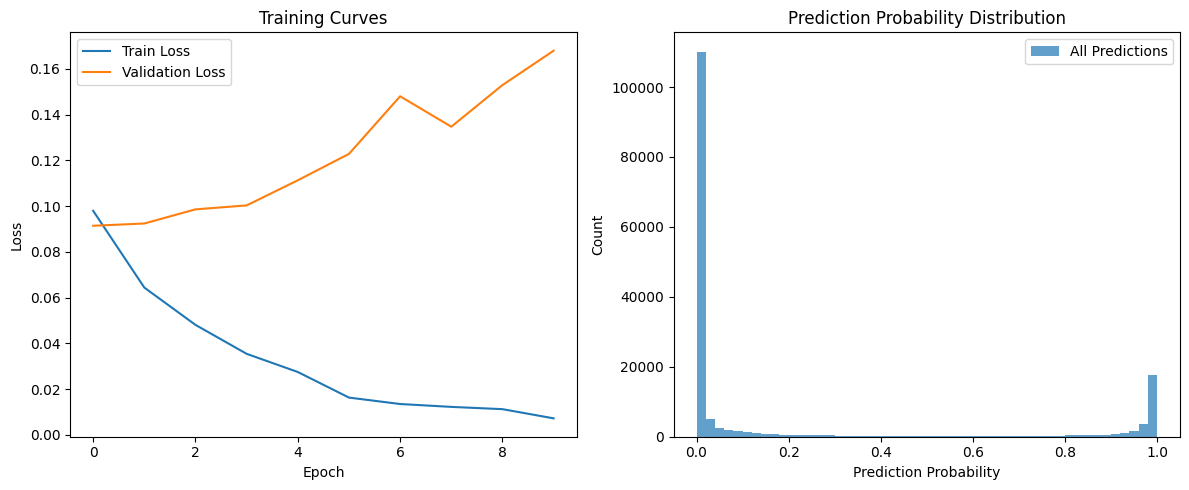

In [23]:
# Load and preprocess data with sliding windows
windows, labels, seq_ids = load_and_preprocess_data(FASTA_PATH)

# Split data (keeping track of sequence IDs to avoid data leakage)
unique_seq_ids = list(set(seq_ids))
train_seq_ids, test_seq_ids = train_test_split(unique_seq_ids, test_size=0.2, random_state=42)
train_seq_ids, val_seq_ids = train_test_split(train_seq_ids, test_size=0.2, random_state=42)

# Create splits based on sequence IDs (no mix/data leakage between sequences)
train_indices = [i for i, seq_id in enumerate(seq_ids) if seq_id in train_seq_ids]
val_indices = [i for i, seq_id in enumerate(seq_ids) if seq_id in val_seq_ids]
test_indices = [i for i, seq_id in enumerate(seq_ids) if seq_id in test_seq_ids]

# Setup of split of windows and labels
train_windows = [windows[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]

val_windows = [windows[i] for i in val_indices]
val_labels = [labels[i] for i in val_indices]

test_windows = [windows[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]

print(f"Train windows: {len(train_windows)}")
print(f"Validation windows: {len(val_windows)}")
print(f"Test windows: {len(test_windows)}")

# Create datasets and loaders
train_dataset = SlidingWindowDataset(train_windows, train_labels, WINDOW_SIZE)
val_dataset = SlidingWindowDataset(val_windows, val_labels, WINDOW_SIZE)
test_dataset = SlidingWindowDataset(test_windows, test_labels, WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model (CNN version)
model = SlidingWindowSignalPeptideClassifier(
    WINDOW_SIZE, num_aa, hidden_dim=128, num_layers=2, use_cnn=False, use_lstm=True
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader, EPOCHS, DEVICE)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# Evaluate model
print("\nFinal Evaluation:")
predictions, labels_true, probabilities = evaluate_model(model, test_loader, DEVICE)

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(probabilities, bins=50, alpha=0.7, label='All Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Example: Predict on a sample sequence
sample_sequence = "MKRREFLRTAGGATAAATAAAGTAAAQEGGGGAQVQPDFGGYLDGVDGGYEDLRGQSEVTIEVGASGNGG"
# correct labels : 11111111111111111111111111000000000000000000000000000000000000000000000
print(f"\nExample prediction for sequence: {sample_sequence}")
preds, probs, pos = predict_sequence(model, sample_sequence, WINDOW_SIZE, DEVICE)

print("Position\tAA\tProbability\tPrediction")
for i, (pred, prob, position) in enumerate(zip(preds, probs, pos)):
    aa = sample_sequence[position] if position < len(sample_sequence) else 'X'
    print(f"{position:3d}\t{aa}\t{prob:.3f}\t\t{'Signal' if pred else 'No Signal'}")

# Save final model
torch.save(model.state_dict(), MODEL_PATH)
print(f"\nFinal model saved to {MODEL_PATH}")



Example prediction for sequence: MKRREFLRTAGGATAAATAAAGTAAAQEGGGGAQVQPDFGGYLDGVDGGYEDLRGQSEVTIEVGASGNGG
Position	AA	Probability	Prediction
  0	M	0.997		Signal
  1	K	0.998		Signal
  2	R	0.998		Signal
  3	R	0.999		Signal
  4	E	0.999		Signal
  5	F	0.998		Signal
  6	L	0.999		Signal
  7	R	0.999		Signal
  8	T	0.999		Signal
  9	A	0.998		Signal
 10	G	0.998		Signal
 11	G	0.998		Signal
 12	A	0.998		Signal
 13	T	0.997		Signal
 14	A	0.997		Signal
 15	A	0.996		Signal
 16	A	0.994		Signal
 17	T	0.990		Signal
 18	A	0.920		Signal
 19	A	0.971		Signal
 20	A	0.832		Signal
 21	G	0.388		No Signal
 22	T	0.789		Signal
 23	A	0.600		Signal
 24	A	0.343		No Signal
 25	A	0.636		Signal
 26	Q	0.411		No Signal
 27	E	0.205		No Signal
 28	G	0.151		No Signal
 29	G	0.095		No Signal
 30	G	0.057		No Signal
 31	G	0.029		No Signal
 32	A	0.023		No Signal
 33	Q	0.016		No Signal
 34	V	0.010		No Signal
 35	Q	0.007		No Signal
 36	P	0.004		No Signal
 37	D	0.003		No Signal
 38	F	0.003		No Signal
 39	G	0.002		No Signal
 40	G	0.001	